# Prescribed-Time Controller Demo

This notebook demonstrates the `PrescribedTimeController` which guarantees heading convergence to line-of-sight (LOS) in a prescribed time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from colav_controllers import PrescribedTimeController

/home/mstolberger/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Controller Parameters

- `a`: Heading dynamics coefficient
- `v`: Ship velocity (m/s)
- `eta`: Controller gain (must be > 1 for guaranteed convergence)
- `tp`: Prescribed time - guaranteed convergence time (seconds)

In [2]:
# Controller parameters
a = 1.0       # Heading dynamics coefficient
v = 2.0       # Ship velocity (m/s)
eta = 2.5     # Controller gain (eta > 1)
tp = 5.0      # Prescribed time (seconds)

controller = PrescribedTimeController(a=a, v=v, eta=eta, tp=tp)

print(f"Prescribed-Time Controller initialized")
print(f"Convergence guaranteed by t = {tp}s")

Prescribed-Time Controller initialized
Convergence guaranteed by t = 5.0s


## Scenario 1: Single Waypoint Navigation

Ship starts with an initial heading and must converge to LOS of a target waypoint.

In [3]:
# Initial state: [x, y, psi]
x0, y0 = 0.0, 0.0
psi0 = np.radians(0)  # Heading east (0°)

# Target waypoint
xw, yw = 50.0, 40.0

print(f"Initial position: ({x0}, {y0})")
print(f"Initial heading: {np.degrees(psi0):.1f}°")
print(f"Target waypoint: ({xw}, {yw})")
print(f"LOS angle: {np.degrees(np.arctan2(yw - y0, xw - x0)):.1f}°")

Initial position: (0.0, 0.0)
Initial heading: 0.0°
Target waypoint: (50.0, 40.0)
LOS angle: 38.7°


In [4]:
# Simulation
t_span = (0, 15)
t_eval = np.linspace(0, 15, 500)

def dynamics(t, state):
    """ODE system for prescribed-time control."""
    x, y, psi = state
    return controller.compute_dynamics(t, x, y, psi, xw, yw)

sol = solve_ivp(dynamics, t_span, [x0, y0, psi0], t_eval=t_eval, method='RK45')

print(f"Simulation complete: {len(sol.t)} time steps")

Simulation complete: 500 time steps


## Visualization

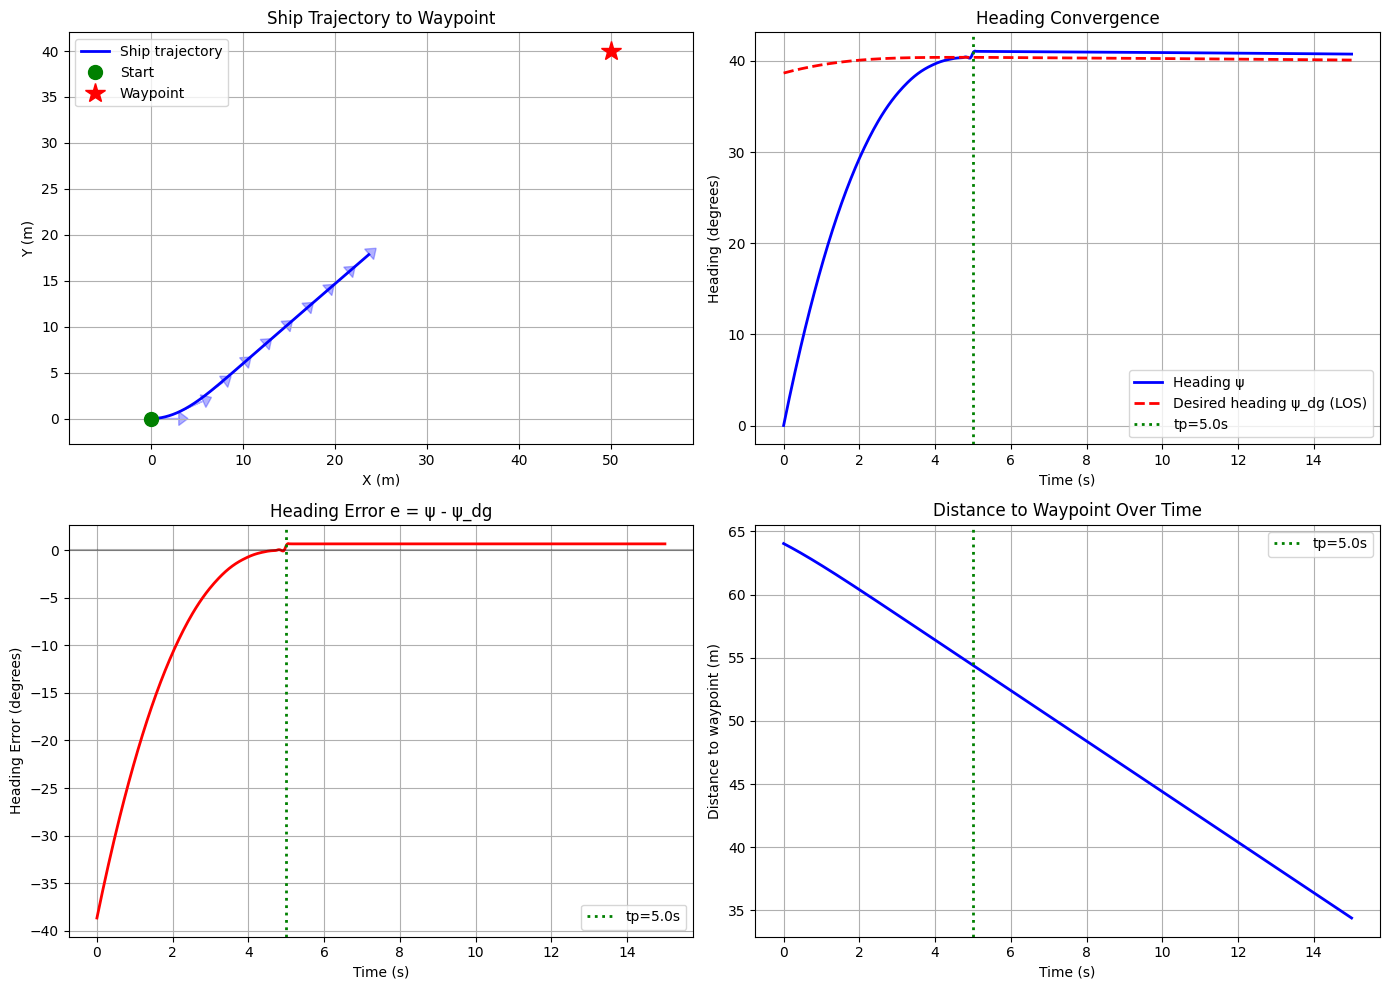

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Trajectory
ax = axes[0, 0]
ax.plot(sol.y[0], sol.y[1], 'b-', linewidth=2, label='Ship trajectory')
ax.plot(x0, y0, 'go', markersize=10, label='Start')
ax.plot(xw, yw, 'r*', markersize=15, label='Waypoint')

# Add heading vectors at various time points
for i in range(0, len(sol.t), len(sol.t)//10):
    x, y, psi = sol.y[:, i]
    dx_arrow = 3 * np.cos(psi)
    dy_arrow = 3 * np.sin(psi)
    ax.arrow(x, y, dx_arrow, dy_arrow, head_width=1.5, head_length=1, fc='blue', ec='blue', alpha=0.3)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Ship Trajectory to Waypoint')
ax.legend()
ax.grid(True)
ax.axis('equal')

# Plot 2: Heading over time
ax = axes[0, 1]
psi_deg = np.degrees(sol.y[2])
ax.plot(sol.t, psi_deg, 'b-', linewidth=2, label='Heading ψ')

# Compute desired heading (LOS) over time
psi_dg_deg = np.degrees(np.arctan2(yw - sol.y[1], xw - sol.y[0]))
ax.plot(sol.t, psi_dg_deg, 'r--', linewidth=2, label='Desired heading ψ_dg (LOS)')

ax.axvline(x=tp, color='g', linestyle=':', linewidth=2, label=f'tp={tp}s')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Heading (degrees)')
ax.set_title('Heading Convergence')
ax.legend()
ax.grid(True)

# Plot 3: Heading error
ax = axes[1, 0]
heading_error = np.degrees(controller.normalize_angle(sol.y[2] - np.arctan2(yw - sol.y[1], xw - sol.y[0])))
ax.plot(sol.t, heading_error, 'r-', linewidth=2)
ax.axvline(x=tp, color='g', linestyle=':', linewidth=2, label=f'tp={tp}s')
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Heading Error (degrees)')
ax.set_title('Heading Error e = ψ - ψ_dg')
ax.legend()
ax.grid(True)

# Plot 4: Distance to waypoint
ax = axes[1, 1]
distance = np.sqrt((sol.y[0] - xw)**2 + (sol.y[1] - yw)**2)
ax.plot(sol.t, distance, 'b-', linewidth=2)
ax.axvline(x=tp, color='g', linestyle=':', linewidth=2, label=f'tp={tp}s')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance to waypoint (m)')
ax.set_title('Distance to Waypoint Over Time')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

## Verify Convergence Guarantee

The controller guarantees that heading error converges to zero by time `tp`.

In [6]:
# Find index closest to tp
tp_idx = np.argmin(np.abs(sol.t - tp))
error_at_tp = heading_error[tp_idx]

# Check error at the end
final_error = heading_error[-1]

print(f"Heading error at t = {sol.t[tp_idx]:.2f}s (prescribed time): {error_at_tp:.3f}°")
print(f"Final heading error at t = {sol.t[-1]:.2f}s: {final_error:.3f}°")
print(f"\nConvergence achieved: {abs(error_at_tp) < 5.0}")

Heading error at t = 4.99s (prescribed time): 0.395°
Final heading error at t = 15.00s: 0.655°

Convergence achieved: True


## Scenario 2: Large Initial Heading Error

Test with ship initially pointing away from waypoint.

In [7]:
# Large initial heading error
x0_2, y0_2 = 0.0, 0.0
psi0_2 = np.radians(-90)  # Heading south
xw_2, yw_2 = 50.0, 40.0    # Target northeast

los_angle = np.degrees(np.arctan2(yw_2 - y0_2, xw_2 - x0_2))
initial_error = np.degrees(controller.normalize_angle(psi0_2 - np.radians(los_angle)))

print(f"Initial heading: {np.degrees(psi0_2):.1f}°")
print(f"LOS angle: {los_angle:.1f}°")
print(f"Initial heading error: {initial_error:.1f}°")

Initial heading: -90.0°
LOS angle: 38.7°
Initial heading error: -128.7°


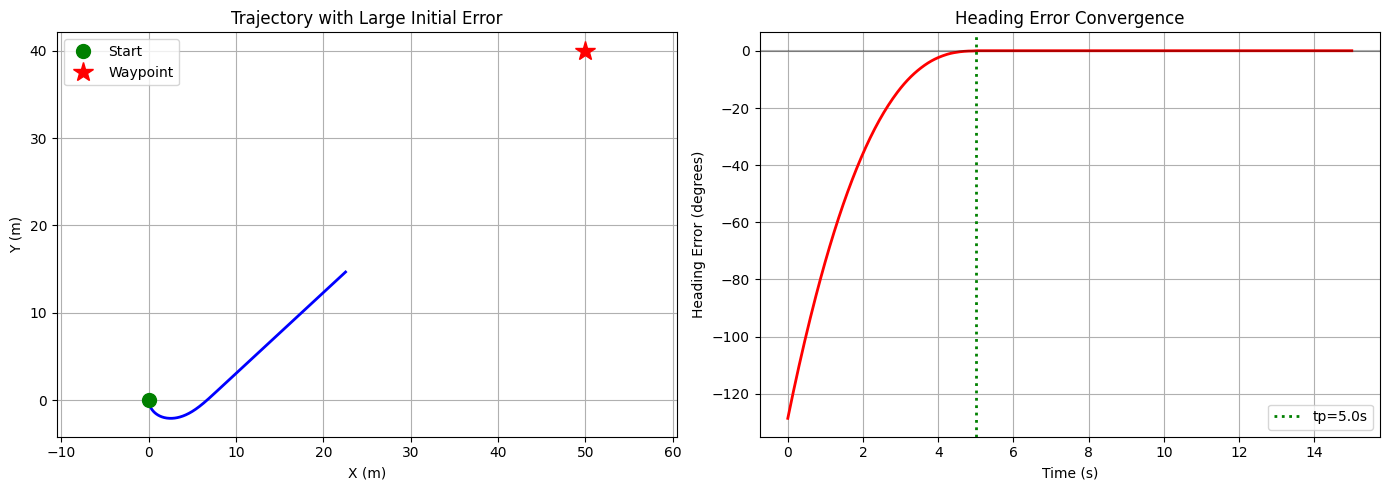

Heading error at tp: 0.067°


In [8]:
# Simulate
sol2 = solve_ivp(dynamics, t_span, [x0_2, y0_2, psi0_2], t_eval=t_eval, method='RK45')

# Plot trajectory
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(sol2.y[0], sol2.y[1], 'b-', linewidth=2)
ax.plot(x0_2, y0_2, 'go', markersize=10, label='Start')
ax.plot(xw_2, yw_2, 'r*', markersize=15, label='Waypoint')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Trajectory with Large Initial Error')
ax.legend()
ax.grid(True)
ax.axis('equal')

# Plot heading error
ax = axes[1]
heading_error_2 = np.degrees(controller.normalize_angle(
    sol2.y[2] - np.arctan2(yw_2 - sol2.y[1], xw_2 - sol2.y[0])
))
ax.plot(sol2.t, heading_error_2, 'r-', linewidth=2)
ax.axvline(x=tp, color='g', linestyle=':', linewidth=2, label=f'tp={tp}s')
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Heading Error (degrees)')
ax.set_title('Heading Error Convergence')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

tp_idx = np.argmin(np.abs(sol2.t - tp))
print(f"Heading error at tp: {heading_error_2[tp_idx]:.3f}°")

## Scenario 3: Multiple Waypoints

Navigate through a sequence of waypoints.

In [9]:
# Waypoint sequence
waypoints = [
    (30.0, 20.0),
    (50.0, 50.0),
    (80.0, 40.0),
    (90.0, 10.0)
]

# Initial state
state = np.array([0.0, 0.0, np.radians(0)])
trajectory = [state.copy()]
times = [0.0]
current_time = 0.0

# Navigate to each waypoint
for i, (xw_i, yw_i) in enumerate(waypoints):
    print(f"Navigating to waypoint {i+1}: ({xw_i}, {yw_i})")
    
    # Simulate until close to waypoint
    def dynamics_wp(t, s):
        return controller.compute_dynamics(t, s[0], s[1], s[2], xw_i, yw_i)
    
    # Simulate for tp + extra time
    t_segment = 10.0
    sol_i = solve_ivp(
        dynamics_wp, 
        (0, t_segment), 
        state, 
        t_eval=np.linspace(0, t_segment, 200),
        method='RK45'
    )
    
    # Add to trajectory
    for j in range(len(sol_i.t)):
        trajectory.append(sol_i.y[:, j])
        times.append(current_time + sol_i.t[j])
    
    # Update state and time
    state = sol_i.y[:, -1]
    current_time += t_segment

trajectory = np.array(trajectory).T
times = np.array(times)

Navigating to waypoint 1: (30.0, 20.0)
Navigating to waypoint 2: (50.0, 50.0)
Navigating to waypoint 3: (80.0, 40.0)
Navigating to waypoint 4: (90.0, 10.0)


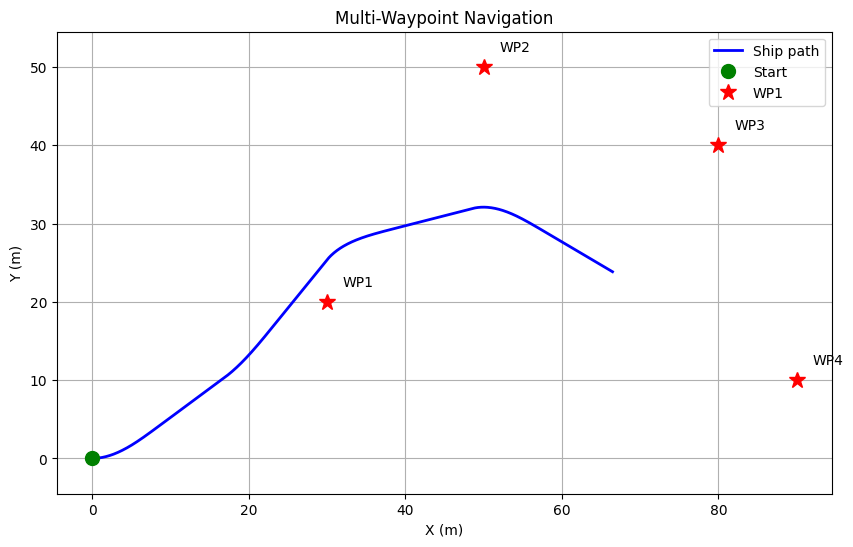

In [10]:
# Plot multi-waypoint navigation
plt.figure(figsize=(10, 6))
plt.plot(trajectory[0], trajectory[1], 'b-', linewidth=2, label='Ship path')
plt.plot(0, 0, 'go', markersize=10, label='Start')

# Plot waypoints
for i, (xw_i, yw_i) in enumerate(waypoints):
    plt.plot(xw_i, yw_i, 'r*', markersize=12, label=f'WP{i+1}' if i == 0 else '')
    plt.text(xw_i + 2, yw_i + 2, f'WP{i+1}', fontsize=10)

plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Multi-Waypoint Navigation')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()